# Importing libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/healthcare-diabetes/Healthcare-Diabetes.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Importing data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nanditapore/healthcare-diabetes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/healthcare-diabetes


In [4]:
# Importing dataset, removing ID column
df = pd.read_csv('/kaggle/input/healthcare-diabetes/Healthcare-Diabetes.csv', index_col=0)

# Data Pre-processing and Exploratory Data Analysis (EDA)

In [5]:
# Checking the first 10 rows 
df.head(10)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
Id                                                                      
1             6      148             72             35        0  33.6   
2             1       85             66             29        0  26.6   
3             8      183             64              0        0  23.3   
4             1       89             66             23       94  28.1   
5             0      137             40             35      168  43.1   
6             5      116             74              0        0  25.6   
7             3       78             50             32       88  31.0   
8            10      115              0              0        0  35.3   
9             2      197             70             45      543  30.5   
10            8      125             96              0        0   0.0   

    DiabetesPedigreeFunction  Age  Outcome  
Id                                          
1                      0.627   50        1  
2                      0.351   31        0  
3                      0.672   32        1  
4                      0.167   21        0  
5                      2.288   33        1  
6                      0.201   30        0  
7                      0.248   26        1  
8                      0.134   29        0  
9                      0.158   53        1  
10                     0.232   54        1

Outcome 0 = have diabetes

Outcome 1 = dont have diabetes

In [6]:
# Display the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2768 entries, 1 to 2768
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2768 non-null   int64  
 1   Glucose                   2768 non-null   int64  
 2   BloodPressure             2768 non-null   int64  
 3   SkinThickness             2768 non-null   int64  
 4   Insulin                   2768 non-null   int64  
 5   BMI                       2768 non-null   float64
 6   DiabetesPedigreeFunction  2768 non-null   float64
 7   Age                       2768 non-null   int64  
 8   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 216.2 KB
None


In [7]:
df.shape

(2768, 9)

In [8]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

# Data Preprocessing # 
preparing data for analysis and modelling

1. Removing duplicates

In [9]:
# Check for missing (NaN) values in the dataset
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [10]:
# Checking if we had duplicates
print(df.duplicated().sum())

1990


In [11]:
# Removing duplicates
df = df.drop_duplicates()

# Print the result
print(df.shape)

(778, 9)


After removing Id from the dataset, the number of distinct rows drops from 2768 to 788. It is definitely not common for different patients to have the same values of that many factors. It is very likely that mistakes were made while inputing the data. Next we shall eliminate all duplicate values.

2.	Handling Missing Data

In [12]:
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

3.	Handling Noisy Data

In [13]:
# Define the relevant ranges for each feature
ranges = {
    'Pregnancies': (0, 12),
    'Glucose': (70, 199),
    'BloodPressure': (60, 122),
    'SkinThickness': (10, 50),
    'BMI': (15, 60),
    'DiabetesPedigreeFunction': (0, 2),
    'Age': (21, 81)
}

# Replace out-of-range values with the mean of the column
for column, (min_val, max_val) in ranges.items():
    # Calculate the mean of the column
    column_mean = df[column].mean()
    
    # Replace values below the minimum or above the maximum with the mean
    df[column] = df[column].apply(lambda x: column_mean if x < min_val or x > max_val else x)

# Print the cleaned data size
print(f"Cleaned Data Size: {df.shape}")

Cleaned Data Size: (778, 9)


4. Feature scaling

In [14]:
# Feature scalling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(df.drop('Outcome', axis=1))

In [15]:
# Convert scaled data back to DataFrame
scaled_dataset = pd.DataFrame(scaled_dataset, columns=df.columns[:-1]) 
scaled_dataset['Outcome'] = df['Outcome']

# Data Visualisation
Visualising data to uncover patterns and insights

In [16]:
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   778.000000  778.000000     778.000000     778.000000  778.000000   
mean      3.645885  122.826719      74.095079      26.324284   80.388175   
std       3.086878   29.572599       9.732478       8.678358  115.113501   
min       0.000000   71.000000      60.000000      10.000000    0.000000   
25%       1.000000  100.000000      68.000000      20.763496    0.000000   
50%       3.000000  119.000000      72.000000      22.000000   36.000000   
75%       6.000000  141.000000      80.000000      32.000000  130.000000   
max      12.000000  199.000000     122.000000      50.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  778.000000                778.000000  778.000000  778.000000  
mean    32.492027                  0.462495   33.347044    0.349614  
std      6.842288                  0.302976   11.789024    0.477155  
min     18.200000                  

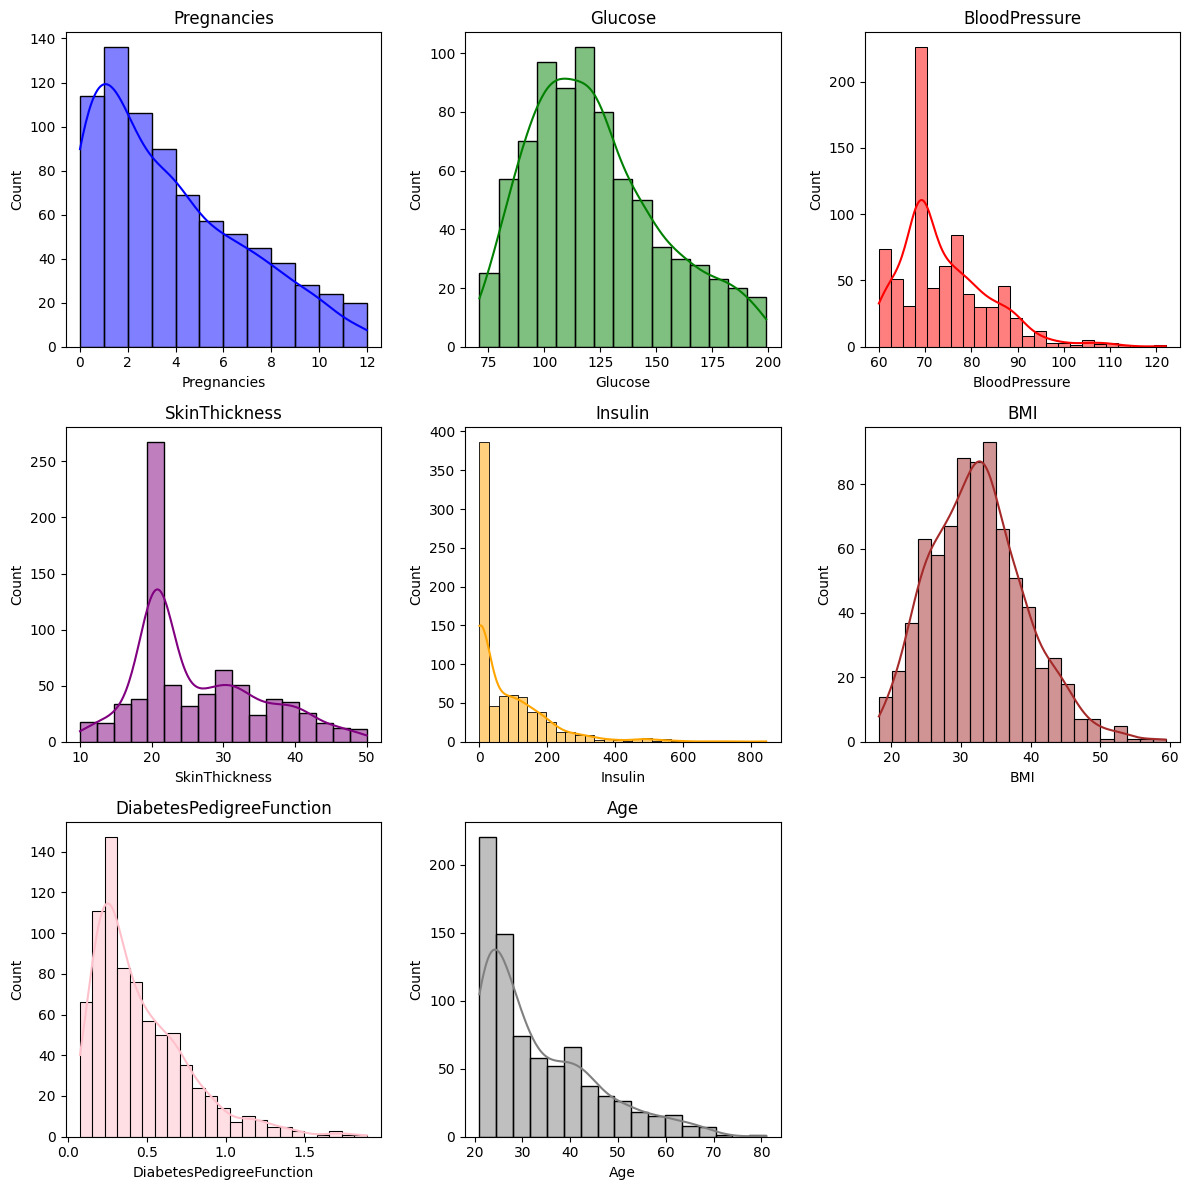

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric columns to plot
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Define a list of colors for each plot
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']

# Set up the figure size
plt.figure(figsize=(12, 12))

# Loop through the columns and create histograms
for i, col in enumerate(columns):
    plt.subplot(3, 3, i+1)  # Creating a 3x3 subplot grid
    sns.histplot(data=df, x=col, kde=True, color=colors[i])  # Histogram with KDE curve and custom color
    plt.title(col)  # Add a title for each plot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

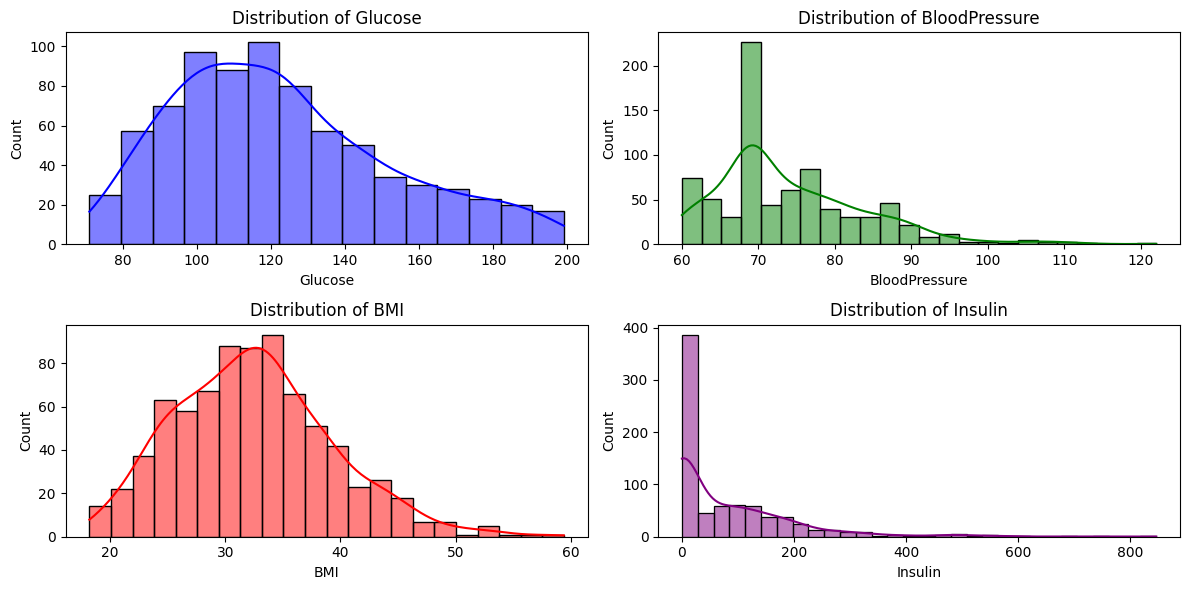

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(df['Glucose'], kde=True, color='blue')
plt.title('Distribution of Glucose')

plt.subplot(2, 2, 2)
sns.histplot(df['BloodPressure'], kde=True, color='green')
plt.title('Distribution of BloodPressure')

plt.subplot(2, 2, 3)
sns.histplot(df['BMI'], kde=True, color='red')
plt.title('Distribution of BMI')

plt.subplot(2, 2, 4)
sns.histplot(df['Insulin'], kde=True, color='purple')
plt.title('Distribution of Insulin')

plt.tight_layout()
plt.show()

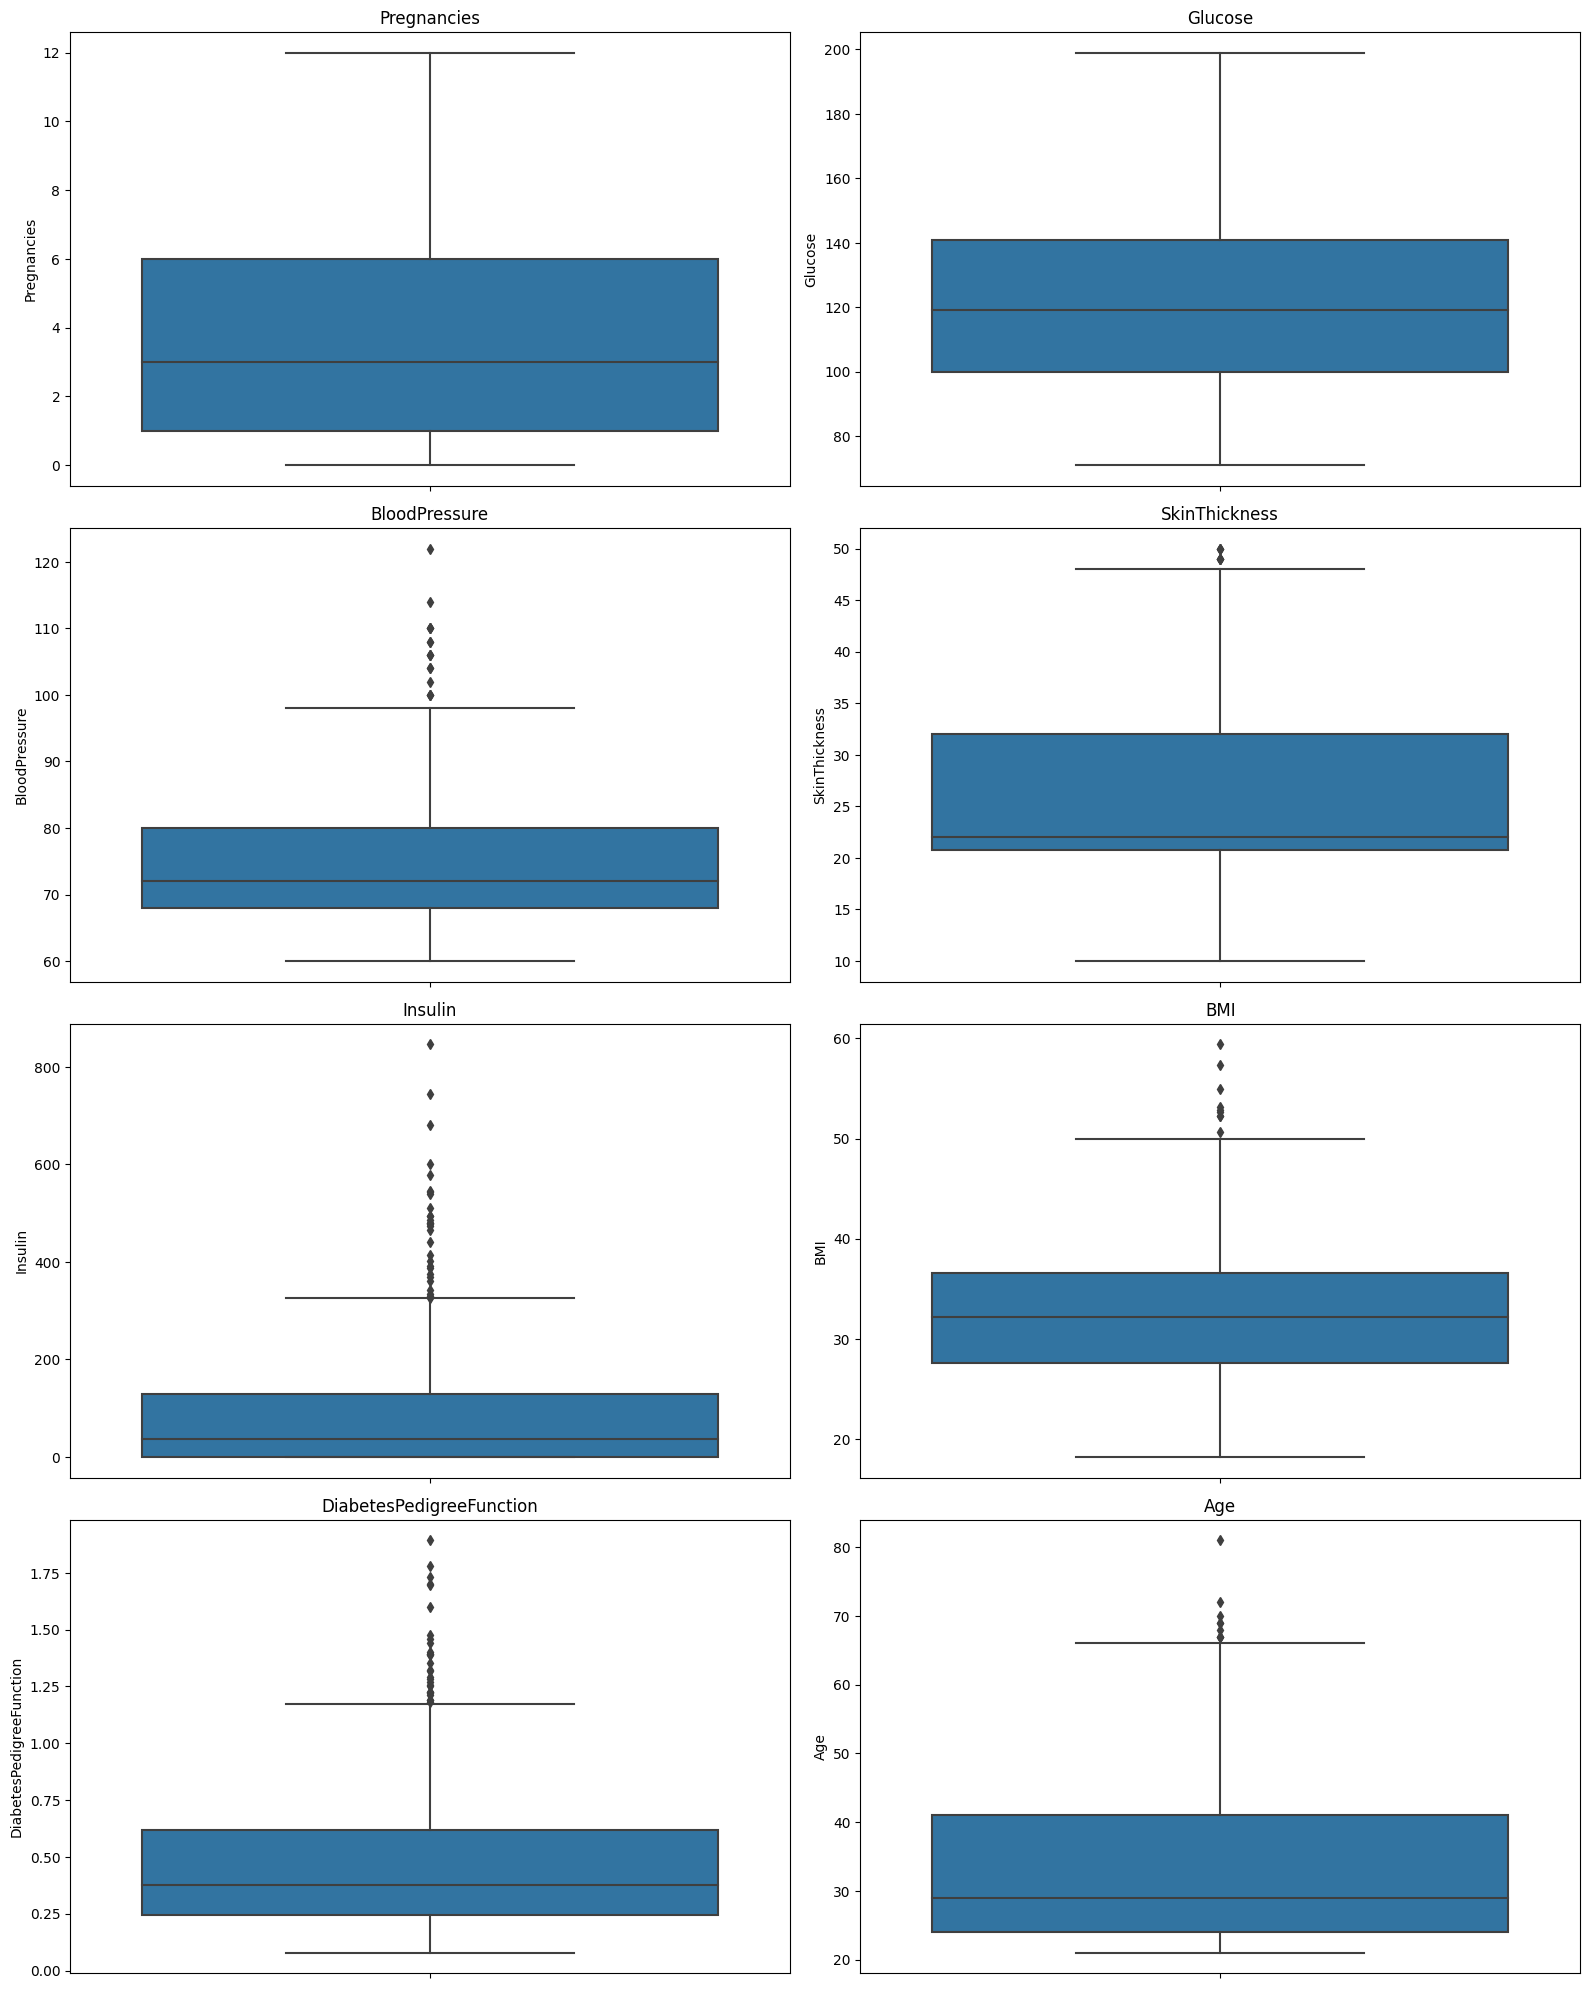

In [19]:
# List of numeric columns to plot
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Set up the figure size
plt.figure(figsize=(16, 20))  # Increase figure size to accommodate more subplots

# Loop through the columns and create boxplots
for i, col in enumerate(columns):
    plt.subplot(len(columns) // 2 + len(columns) % 2, 2, i+1)  # Create subplots in 2 columns
    sns.boxplot(data=df, y=col)  # Create boxplot for each column
    plt.title(col)  # Add a title for each plot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots

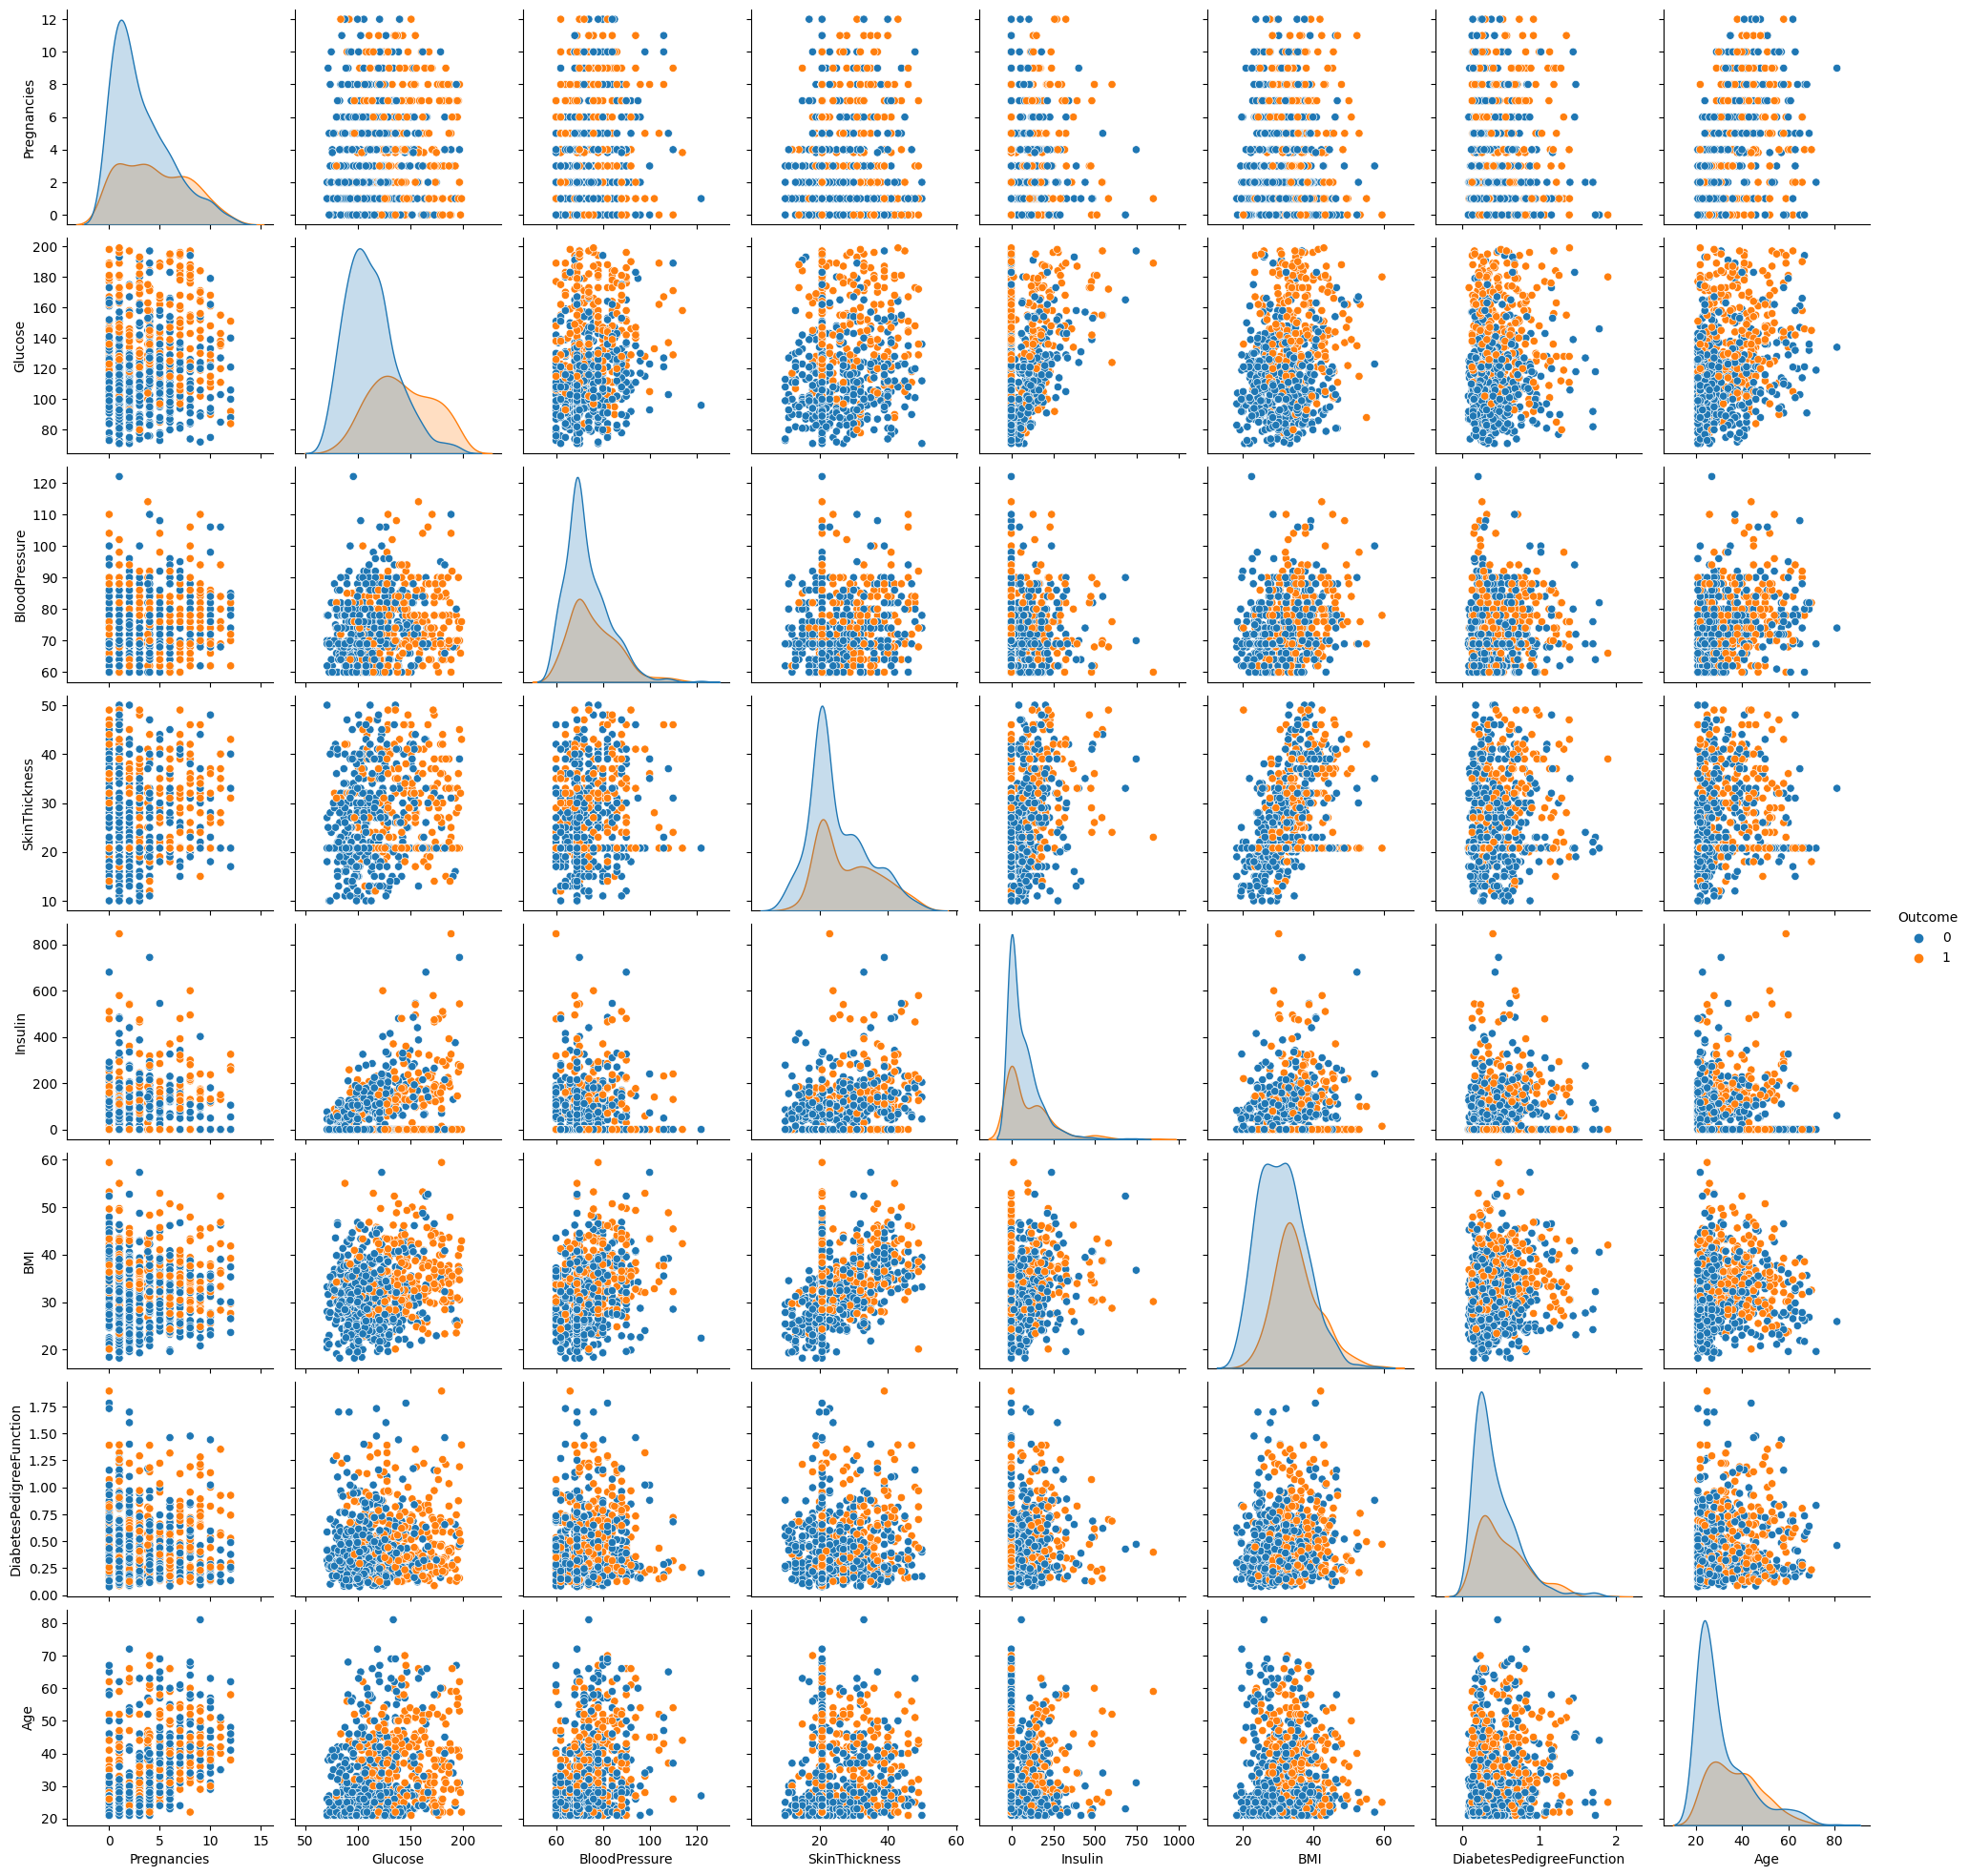

In [20]:
sns.pairplot(df, hue = "Outcome")

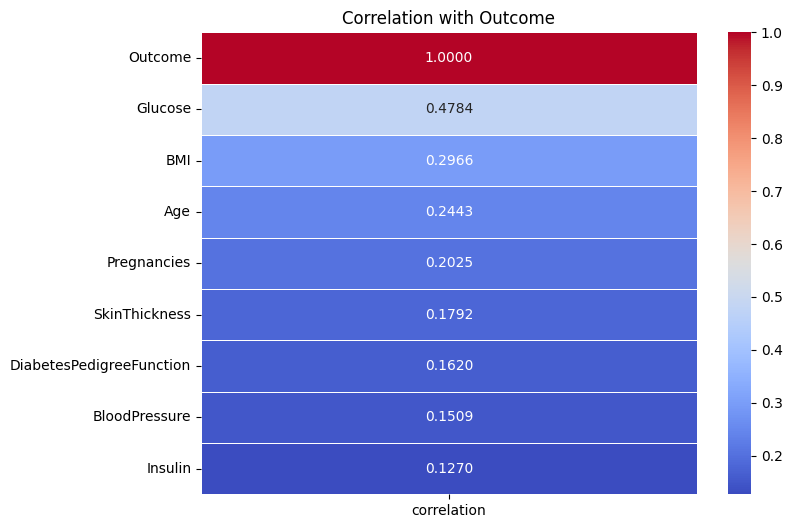

In [21]:
# Checking corrlation between data columns
correlation_with_outcome = df.corrwith(df['Outcome']).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(correlation_with_outcome, columns=['correlation']), annot=True, cmap='coolwarm', fmt=".4f", linewidths=.5)

plt.title('Correlation with Outcome')
plt.show()

<Axes: >

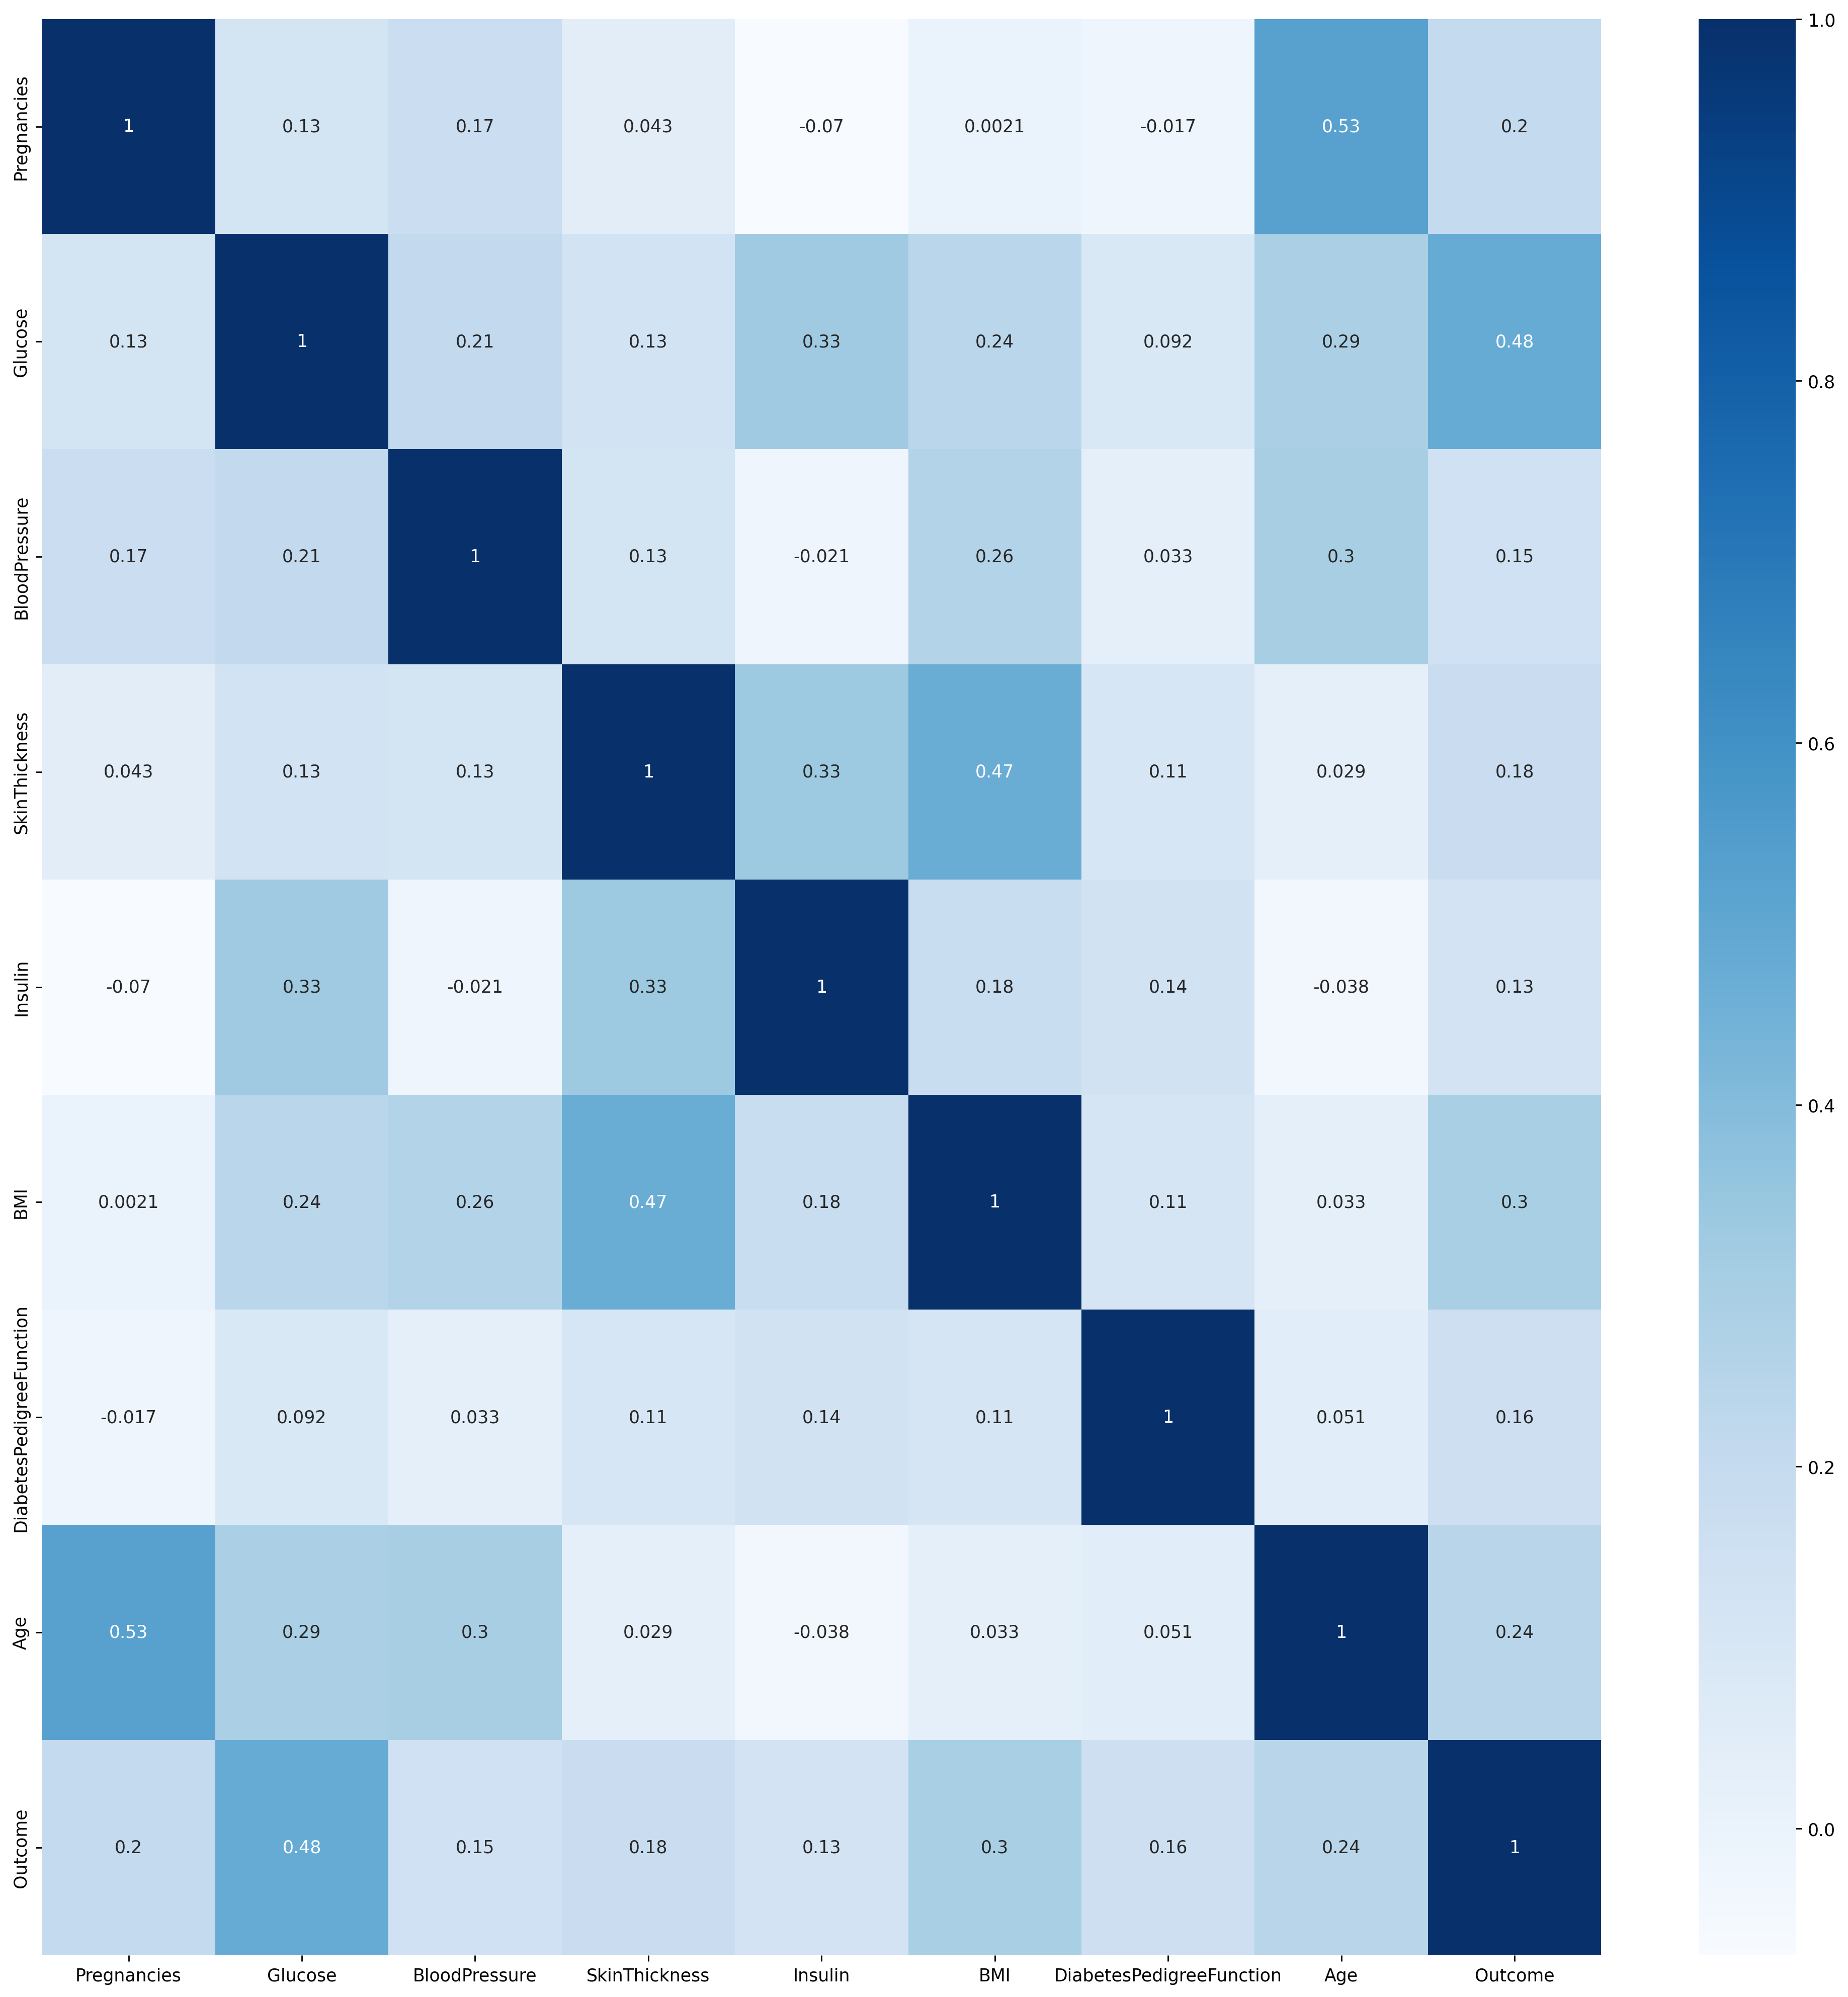

In [22]:
fig = plt.figure(figsize=(20,20), dpi=250)
sns.heatmap(df.corr(), cmap="Blues", annot=True)

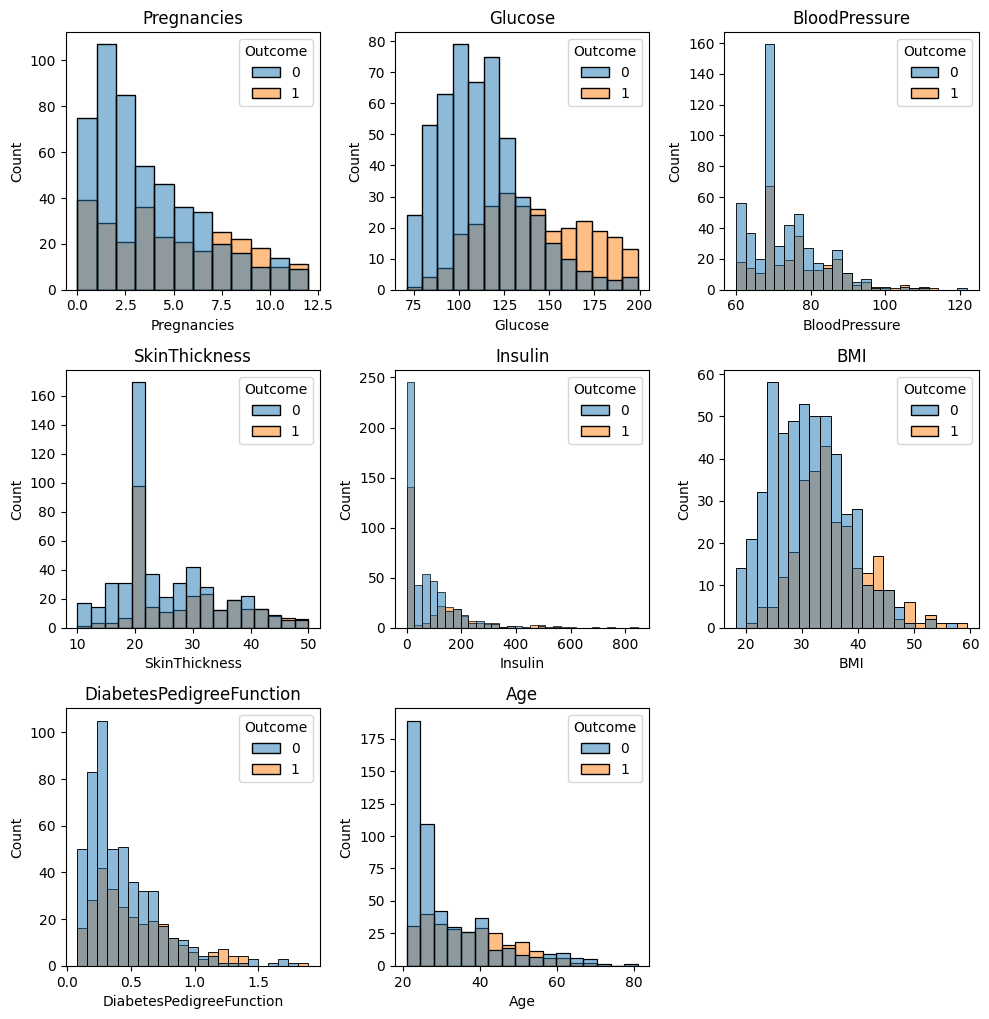

In [23]:
num_list=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
fig = plt.figure(figsize=(10,20))

for i in range(len(num_list)):
    plt.subplot(6,3,i+1)
    plt.title(num_list[i])
    sns.histplot(data=df,x=df[num_list[i]],hue='Outcome')

plt.tight_layout()

# Removing Outliear

In [24]:
"""num_col = ['Pregnancies','Glucose','BloodPressure','SkinThickness'
           ,'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
no_outlier = df
for i in num_col:
    lower_limit = df[i].quantile(0.5)
    upper_limit = df[i].quantile(0.95)
    no_outlier[i] = no_outlier[i].clip(lower_limit, upper_limit)
df.plot(kind = "box" , subplots = True , figsize = (15,15) , layout = (5,5))"""

'num_col = [\'Pregnancies\',\'Glucose\',\'BloodPressure\',\'SkinThickness\'\n           ,\'Insulin\', \'BMI\', \'DiabetesPedigreeFunction\', \'Age\', \'Outcome\']\nno_outlier = df\nfor i in num_col:\n    lower_limit = df[i].quantile(0.5)\n    upper_limit = df[i].quantile(0.95)\n    no_outlier[i] = no_outlier[i].clip(lower_limit, upper_limit)\ndf.plot(kind = "box" , subplots = True , figsize = (15,15) , layout = (5,5))'

In [25]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [26]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.3 , random_state=17)

# Classification Models and Decision Tree Implementation

# Decision Tree

In [27]:
DT_model = DecisionTreeClassifier(random_state=20)
DT_model.fit(X_train , y_train)


DecisionTreeClassifier(random_state=20)

In [28]:
DT_model.score(X_test , y_test)

0.6794871794871795

In [29]:
DT_model.score(X_train , y_train)

1.0

In [30]:
DT_pred=DT_model.predict(X_test)
DT_acc = accuracy_score(y_test ,DT_pred )

In [31]:
print(classification_report(y_test , DT_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       152
           1       0.54      0.54      0.54        82

    accuracy                           0.68       234
   macro avg       0.65      0.65      0.65       234
weighted avg       0.68      0.68      0.68       234



Text(95.72222222222221, 0.5, 'Truh')

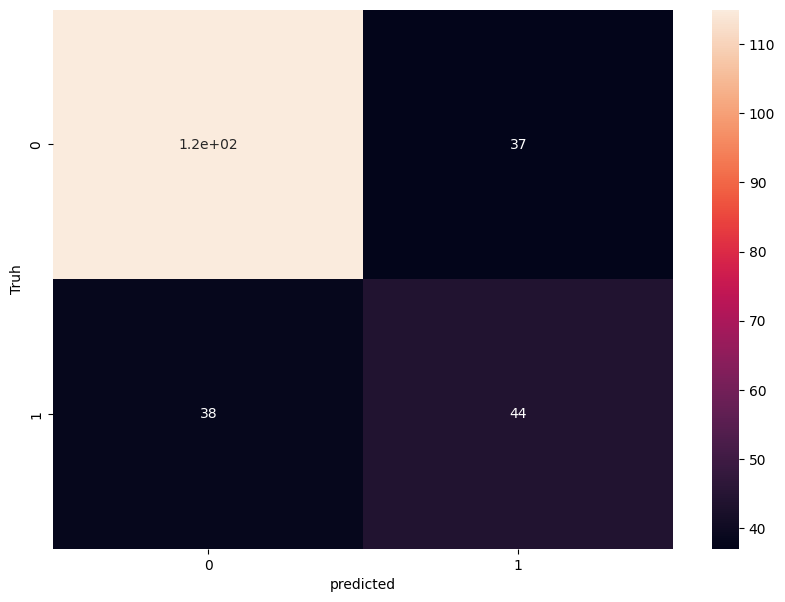

In [32]:
cm2 = confusion_matrix(y_test,DT_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm2,annot=True)
plt.xlabel('predicted')
plt.ylabel('Truh')


In [33]:
print(confusion_matrix(y_test,DT_pred))

[[115  37]
 [ 38  44]]


In [34]:
!pip install pydot
!pip install graphviz

In [35]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(df.columns[1:])
features

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

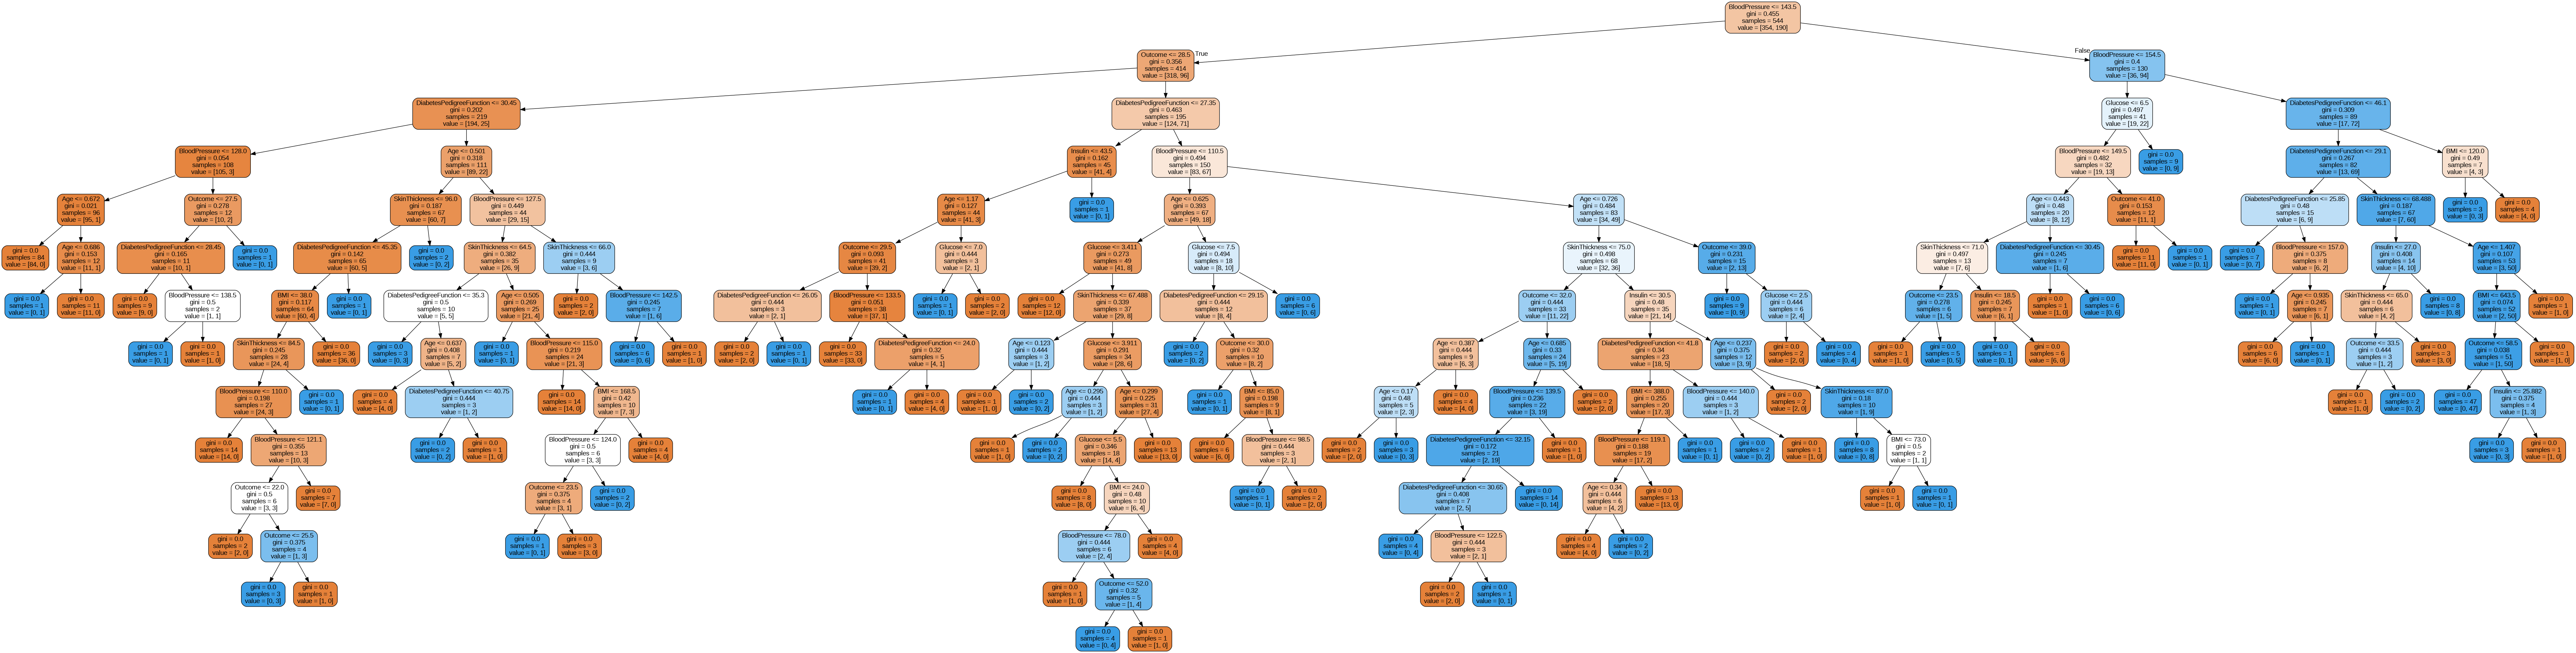

In [36]:
dot_data = StringIO()
export_graphviz(DT_model, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

# SVM

In [37]:
from sklearn import svm
svc = svm.SVC(kernel='rbf')
svc.fit(X_train, y_train)

SVC()

In [38]:
svc.score(X_train , y_train)

0.7628676470588235

In [39]:
svc.score(X_test,y_test)

0.7222222222222222

In [40]:
svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(y_test , svc_pred)

In [41]:
print(classification_report(y_test , svc_pred))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80       152
           1       0.66      0.43      0.52        82

    accuracy                           0.72       234
   macro avg       0.70      0.65      0.66       234
weighted avg       0.71      0.72      0.70       234



Text(95.72222222222221, 0.5, 'Truh')

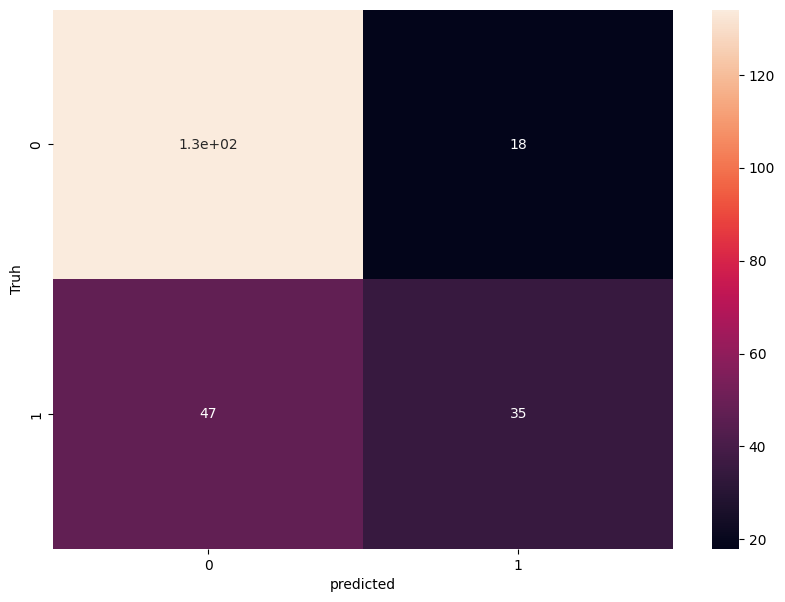

In [42]:
cm2 = confusion_matrix(y_test,svc_pred)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm2,annot=True)
plt.xlabel('predicted')
plt.ylabel('Truh')

# Random Forest

In [43]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(X_train , y_train)

RandomForestClassifier()

In [44]:
RF_model.score(X_train , y_train)

1.0

In [45]:
RF_model.score(X_test , y_test)

0.7264957264957265

In [46]:
RF_pred = RF_model.predict(X_test)
RF_acc=accuracy_score(y_test , RF_pred)
print(classification_report(y_test , RF_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       152
           1       0.64      0.51      0.57        82

    accuracy                           0.73       234
   macro avg       0.70      0.68      0.68       234
weighted avg       0.72      0.73      0.72       234



Text(95.72222222222221, 0.5, 'Truh')

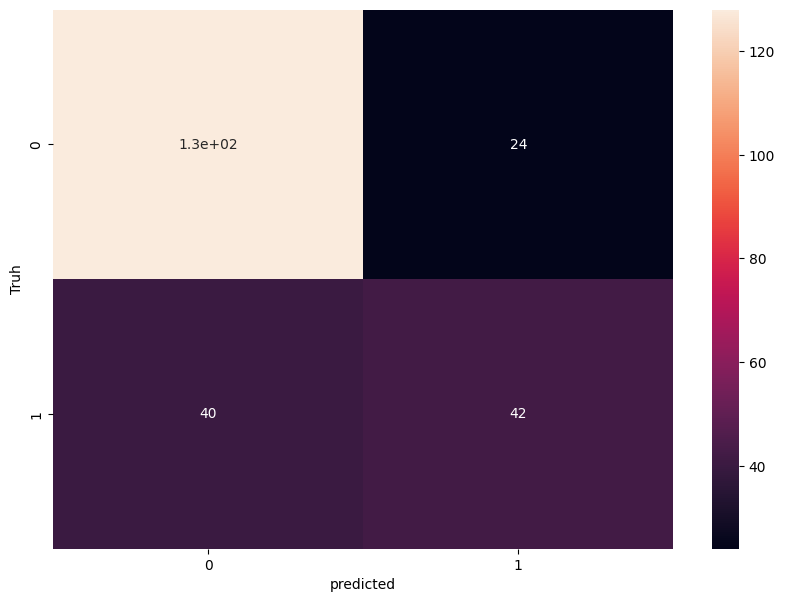

In [47]:
cm3 = confusion_matrix(y_test,RF_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm3,annot=True)
plt.xlabel('predicted')
plt.ylabel('Truh')

# Model scores

In [48]:
models=pd.DataFrame({
    'models':['Decsion_Tree','SVC','Random_Forest'],
    'scores':[DT_acc,svc_acc,RF_acc]})
models.sort_values(by='scores',ascending=False)

models    scores
2  Random_Forest  0.726496
1            SVC  0.722222
0   Decsion_Tree  0.679487